### Import libs

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path

### Load hotels from file

In [14]:
hotels_path = Path("../data/places.json")
amenities_path = Path("../data/place_amenities.json")
with hotels_path.open("r") as file:
    hotels = json.load(file)

with amenities_path.open("r") as file:
    place_amenities = json.load(file)

group_weights: dict = {
    key: 1 / len(place_amenities)
    for key in place_amenities.keys()
}

# np.concatenate(list(amenities.values())) принимает список значений словаря amenities и объединяет их в один массив кодов удобств.
all_amenities: np.ndarray = np.concatenate(
    list(place_amenities.values())
)
# Повторение названия каждой группы удобств по количеству удобств в каждой группе
all_groups: np.ndarray = np.repeat(
    list(place_amenities.keys()),
    [len(v) for v in place_amenities.values()],
)
# np.repeat повторяет каждый вес группы удобств соответствующее количество раз, определяемое длиной соответствующего списка удобств.
# если у есть список весов групп удобств [0.2, 0.5, 0.8], а соответствующие списки удобств имеют длины [3, 2, 4],
# то np.repeat создаст массив [0.2, 0.2, 0.2, 0.5, 0.5, 0.8, 0.8, 0.8, 0.8], чтобы каждая группа имела свой вес.
all_weights: np.ndarray = np.repeat(
    [group_weights[key] for key in place_amenities.keys()],
    [len(v) for v in place_amenities.values()],
)

amenity_pd_data: pd.DataFrame = pd.DataFrame(
    {
        "amenities_keys": all_amenities,
        "amenities_groups": all_groups,
        "amenities_weights": all_weights,
    }
)
# поиск пересечний удобств между заданными важными удобствами и всеми удобствами отеля
amenities_set = set(amenity_pd_data["amenities_keys"])


hotels_pd = pd.DataFrame(hotels)
print(len(hotels))
scores = np.zeros((len(hotels), 4), dtype=np.float32)

700


In [15]:
def count_place_amenities_weight(
    amenities_set, amenity_pd_data, hotel_amenety_list
) -> float:
    intersecting_amenities = amenities_set & set(hotel_amenety_list)

    # оставляем только те данные, которые соответствуют пересечению из приоритетной группы удобств и удобств отеля
    filtered_data: pd.DataFrame = amenity_pd_data[
        amenity_pd_data["amenities_keys"].isin(intersecting_amenities)
    ]
    # уникальные группы, которые пересеклись
    unique_groups: pd.DataFrame = filtered_data.drop_duplicates(
        subset="amenities_groups", keep=False
    )
    total_weight: float = unique_groups["amenities_weights"].sum()

    return total_weight

In [16]:
count_last_reviews = hotels_pd["count_last_reviews"]
rating = hotels_pd["rating"]
stars = hotels_pd["stars"]
scores[:, 0] = count_last_reviews
scores[:, 1] = rating
scores[:, 2] = stars
for i, hotel in enumerate(hotels):
    amenity_codes = pd.json_normalize(hotel, "amenity")
    amenity_weight = 0.0 if amenity_codes.empty else count_place_amenities_weight(
            amenities_set, amenity_pd_data, amenity_codes["code"])
    scores[i, 3] = amenity_weight
scores[np.isnan(scores)] = 0
scores_max = np.max(scores, axis=0)/10
scores /= scores_max

#### Set weights for count_last_reviews, rating, stars, amenity 

In [17]:
weights = np.array((0.25, 0.25, 0.25, 0.25), dtype=np.float32)
weights_scores = weights*scores
hotels_scores = np.sum(weights_scores, axis=1)

### Hotels scores histogram

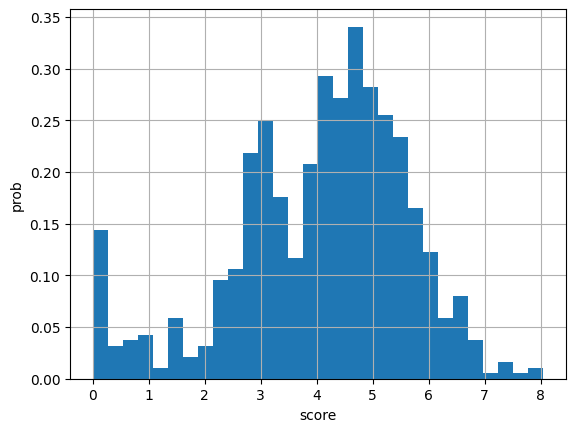

In [18]:
_, axes = plt.subplots()
axes.hist(hotels_scores, bins=30, density=True)
axes.set_xlabel("score")
axes.set_ylabel("prob")
axes.grid(True)


##### Return sorted places by hotel_scores without price 

In [19]:
hotels_pd_with_scores = hotels_pd.assign(hotel_score=hotels_scores)
hotels_pd_with_scores = hotels_pd_with_scores.sort_values(by=['hotel_score'])
hotels_pd_with_scores[["hotel_score", "price", "count_last_reviews", "rating", "stars"]]


,hotel_score,price,count_last_reviews,rating,stars
529,0.000000,36950,0,0.00,0.0
657,0.000000,18614,0,0.00,0.0
658,0.000000,18563,0,0.00,0.0
370,0.000000,17533,0,0.00,0.0
639,0.000000,16182,0,0.00,0.0
558,0.000000,15593,0,0.00,0.0
522,0.000000,29353,0,0.00,0.0
517,0.000000,18936,0,0.00,0.0
668,0.000000,82501,0,0.00,0.0
568,0.000000,13420,0,0.00,0.0


<Axes: ylabel='Frequency'>

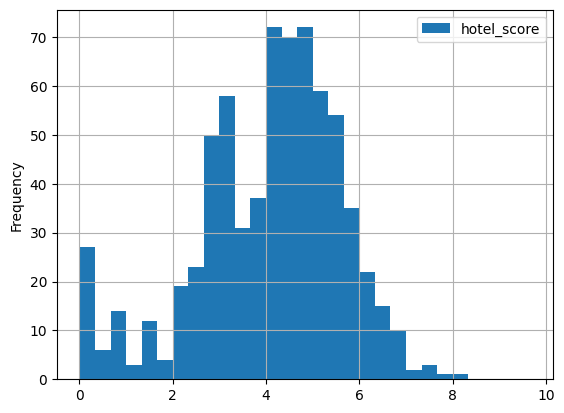

In [20]:
hotels_pd_with_scores.plot.hist(column="hotel_score", grid=True, bins=np.arange(0, 10, 10/30))

#### Division of places into subgroups according to the score

In [21]:
# границы интервалов для каждой подгруппы по 'scores'
score_bins = [0.0, 2, 5, 7, 10]
# создать новый столбец 'score_group', разделив значения по интервалам
hotels_pd_with_scores['score_group'] = pd.cut(hotels_pd_with_scores['hotel_score'], bins=score_bins, include_lowest=True)


(-0.001, 2.0] 1439 86347 18230.0 17799.268470317296
(2.0, 5.0] 4351 77659 17107.0 8545.657163581463
(5.0, 7.0] 12312 329377 26824.0 29904.7066349194
(7.0, 10.0] 14467 35452 30005.0 8693.584353117067


,hotel_score,price,score_group,count_last_reviews,rating,stars
529,0.647233,36950,"(-0.001, 2.0]",0,0.00,0.0
657,1.236517,18614,"(-0.001, 2.0]",0,0.00,0.0
658,1.238307,18563,"(-0.001, 2.0]",0,0.00,0.0
370,1.274471,17533,"(-0.001, 2.0]",0,0.00,0.0
639,1.321834,16182,"(-0.001, 2.0]",0,0.00,0.0
558,1.342426,15593,"(-0.001, 2.0]",0,0.00,0.0
522,0.871662,29353,"(-0.001, 2.0]",0,0.00,0.0
517,1.225213,18936,"(-0.001, 2.0]",0,0.00,0.0
668,0.065792,82501,"(-0.001, 2.0]",0,0.00,0.0
568,1.417877,13420,"(-0.001, 2.0]",0,0.00,0.0


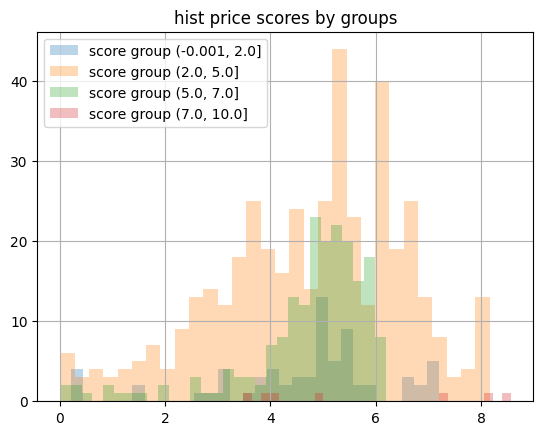

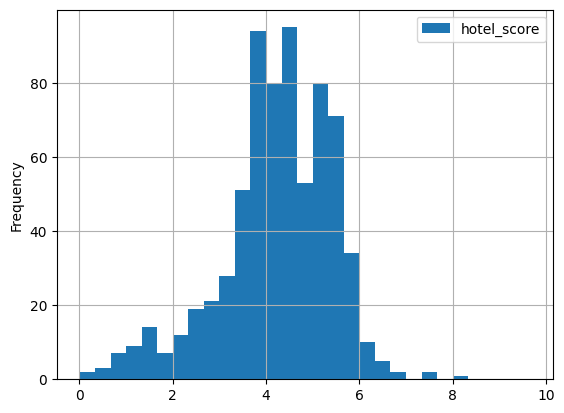

In [22]:
price_weight = 0.25
hotels_pd_with_scores_and_price = hotels_pd_with_scores.copy()
# Группировка средств размещения по score_group
grouped_hotels = hotels_pd_with_scores_and_price.groupby('score_group')
_, axes = plt.subplots(1)

# Пройтись по каждой группе и изменить скор в зависимости от прайса
for group_name, group_data in grouped_hotels:
    indexes = group_data.index
    # Получить медианное значение прайса
    # std https://www.nlm.nih.gov/nichsr/stats_tutorial/section2/mod8_sd.html#:~:text=A%20standard%20deviation%20(or%20%CF%83,data%20are%20more%20spread%20out.
    median_price, std_price = group_data['price'].median(), group_data['price'].std()
    min_price, max_price = group_data['price'].min(), group_data['price'].max()
    print(group_name, min_price, max_price, median_price, std_price)
    price_score = group_data['price']
    price_score = (group_data['price'] - median_price)/(std_price) #mean std norm
    # Sigmoid https://en.wikipedia.org/wiki/Sigmoid_function
    price_score = (1 - 1 / (1 + np.exp(-1*price_score)))*10 # sigmoid norm
    axes.hist(price_score, bins=30, label=f"score group {group_name}", alpha=0.3)
    total_group_score = group_data['hotel_score'] * (1 - price_weight) + price_score * price_weight
    hotels_pd_with_scores_and_price.loc[group_data.index, 'hotel_score']  = total_group_score
axes.grid(True)
axes.legend()
axes.set_title("hist price scores by groups")
hotels_pd_with_scores_and_price.plot.hist(column="hotel_score", grid=True, bins=np.arange(0, 10, 10/30))
pd.set_option('display.max_rows', None)
hotels_pd_with_scores_and_price[["hotel_score", "price", "score_group", "count_last_reviews", "rating", "stars"]]